# Explore here

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import seaborn as sns
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv",sep=',')
data.to_csv('/workspaces/serie-tempalt-joeld/data/raw/sales.csv',index=False)
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [157]:
data.date = pd.to_datetime(data.date)

In [158]:
print(data.date.min(),data.date.max())
print((data.date.max()-data.date.min()).days)
print(len(set(data.date)))

2022-09-03 17:10:08.079328 2023-09-03 17:10:08.079328
365
366


como podemos ver aqui la resta me da 365 dias aunque luego de investigalo entre estas fechas has 366  como la longitud indica esto puede pasar debido a que la ultima fecha no esta considerando el dia completo utilizaremos timedelta para asegurarnos que utiliza el dia completo y que no se trata de algun otro problema para que no exista otro problema vamos a quedarnos unicamente con las fechas sin tener en cuenta las horas 

In [159]:
data['date'] = data['date'].dt.date

In [160]:
# Ajustar la fecha máxima para incluir todo el día
fecha_max = data['date'].max() + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
# Calcular la diferencia en días
diferencia_dias = (fecha_max - data['date'].min()).days

print("El número de días entre la fecha mínima y la fecha máxima es:", diferencia_dias)

El número de días entre la fecha mínima y la fecha máxima es: 366


In [161]:
data

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633
...,...,...
361,2023-08-30,989.600354
362,2023-08-31,994.987326
363,2023-09-01,995.814415
364,2023-09-02,997.350214


In [162]:
data_sc = pd.DataFrame(data=StandardScaler().fit_transform(data.drop(['date'], axis=1)), columns=data.columns[-1:])
data_sc['date'] = data.date
data_sc

,sales,date
0,-1.709678,2022-09-03
1,-1.715098,2022-09-04
2,-1.699305,2022-09-05
3,-1.676047,2022-09-06
4,-1.670650,2022-09-07
...,...,...
361,1.691348,2023-08-30
362,1.710958,2023-08-31
363,1.713968,2023-09-01
364,1.719559,2023-09-02


In [163]:
data_sc.set_index('date',inplace=True, drop=True)
data_sc.head()

,sales
date,
2022-09-03,-1.709678
2022-09-04,-1.715098
2022-09-05,-1.699305
2022-09-06,-1.676047
2022-09-07,-1.670650


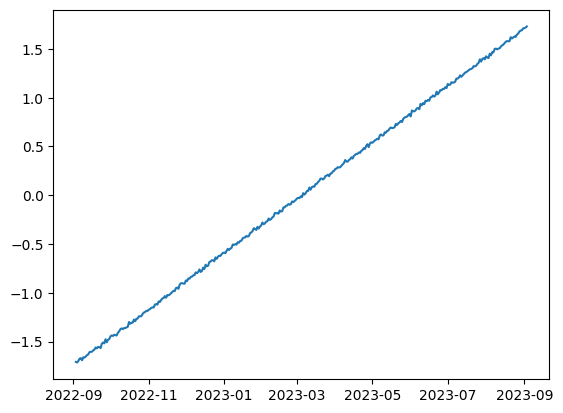

In [164]:
plt.plot(data_sc)

In [165]:
df_train = data_sc.iloc[:-30]
df_test = data_sc.iloc[-30:]

In [166]:
n = 4
XY_train = np.array([df_train[i:i+n].sales.values for i in range(len(df_train)) if len(df_train[i:i+n])==n])
X_train, y_train = XY_train[:,:-1], XY_train[:,-1]
XY_test = np.array([df_test[i:i+n].sales.values for i in range(len(df_test)) if len(df_test[i:i+n])==n])
X_test, y_test = XY_test[:,:-1], XY_test[:,-1]

In [167]:
# Crear el modelo de regresión lineal
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const)

# Ajustar el modelo a los datos
results = model.fit()

In [168]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.051e+05
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:34:05   Log-Likelihood:                 993.46
No. Observations:                 333   AIC:                            -1979.
Df Residuals:                     329   BIC:                            -1964.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.001     18.433      0.0

In [169]:
def wf_validation(X_train, y_train, X_test, y_test):
  y_pred = []
  for i in range(len(y_test)):
    yhat = LinearRegression().fit(X_train,y_train).predict(np.array([X_test[i]]))[0]
    y_pred.append(yhat)
    X_train, y_train = np.vstack((X_train, X_test[i])), np.hstack((y_train, y_test[i]))
  return y_pred
y_pred = wf_validation(X_train, y_train, X_test, y_test)

In [170]:
print(r2_score(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred)*100, mean_absolute_error(y_test,y_pred))

0.9785670182670662 0.5647503571815701 0.008935640880828865


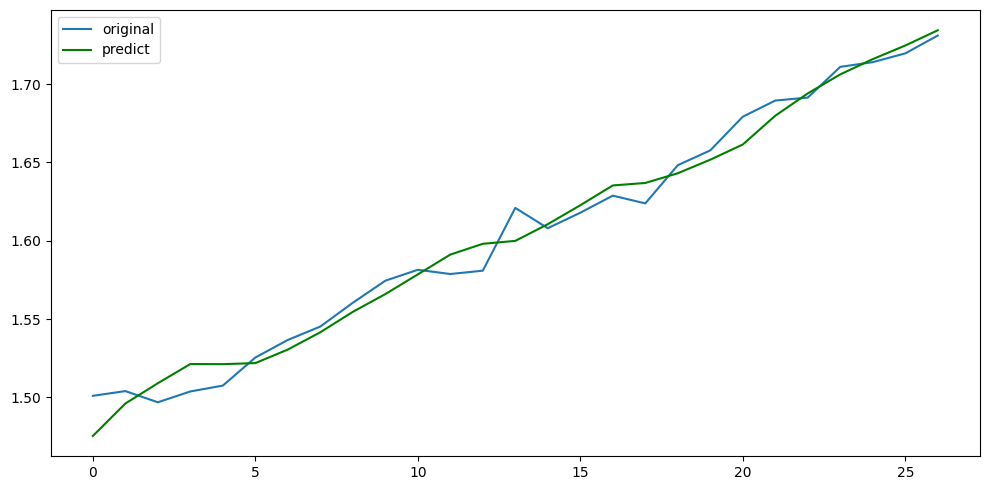

In [171]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = y_test,label='original')
sns.lineplot(data = y_pred, c = "green",label='predict')

plt.tight_layout()

plt.show()

In [172]:
in_len, out_len = 6, 2
n = in_len+out_len

XY_train = np.array([df_train[i:i+n].sales.values for i in range(len(df_train)) if len(df_train[i:i+n])==n])
X_train, y_train = XY_train[:,:in_len], XY_train[:,-out_len:]
XY_test = np.array([df_test[i:i+n].sales.values for i in range(len(df_test)) if len(df_test[i:i+n])==n])
X_test, y_test = XY_test[:,:in_len], XY_test[:,-out_len:]

In [173]:
y_test[:, 0]

array([1.50378231, 1.5075099 , 1.52542749, 1.53665533, 1.54520869,
       1.56037696, 1.57445778, 1.58143282, 1.578744  , 1.58086183,
       1.62093888, 1.60798283, 1.61786296, 1.62876905, 1.62380788,
       1.64818973, 1.65764574, 1.67913277, 1.68946002, 1.6913481 ,
       1.71095751, 1.71396825, 1.71955879])

In [174]:
modelo = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)
y_pred_multi = modelo.predict(X_test)

In [175]:
print(r2_score(y_test[:,0],y_pred_multi[:,0]), mean_absolute_percentage_error(y_test[:,0],y_pred_multi[:,0])*100, mean_absolute_error(y_test[:,0],y_pred_multi[:,0]))

0.9783576241144253 0.49949769673190797 0.008029913164076525


In [176]:
print(r2_score(y_test[:,1],y_pred_multi[:,1]), mean_absolute_percentage_error(y_test[:,1],y_pred_multi[:,1])*100, mean_absolute_error(y_test[:,1],y_pred_multi[:,1]))

0.9802631602419161 0.47631324644677714 0.007716394468282298


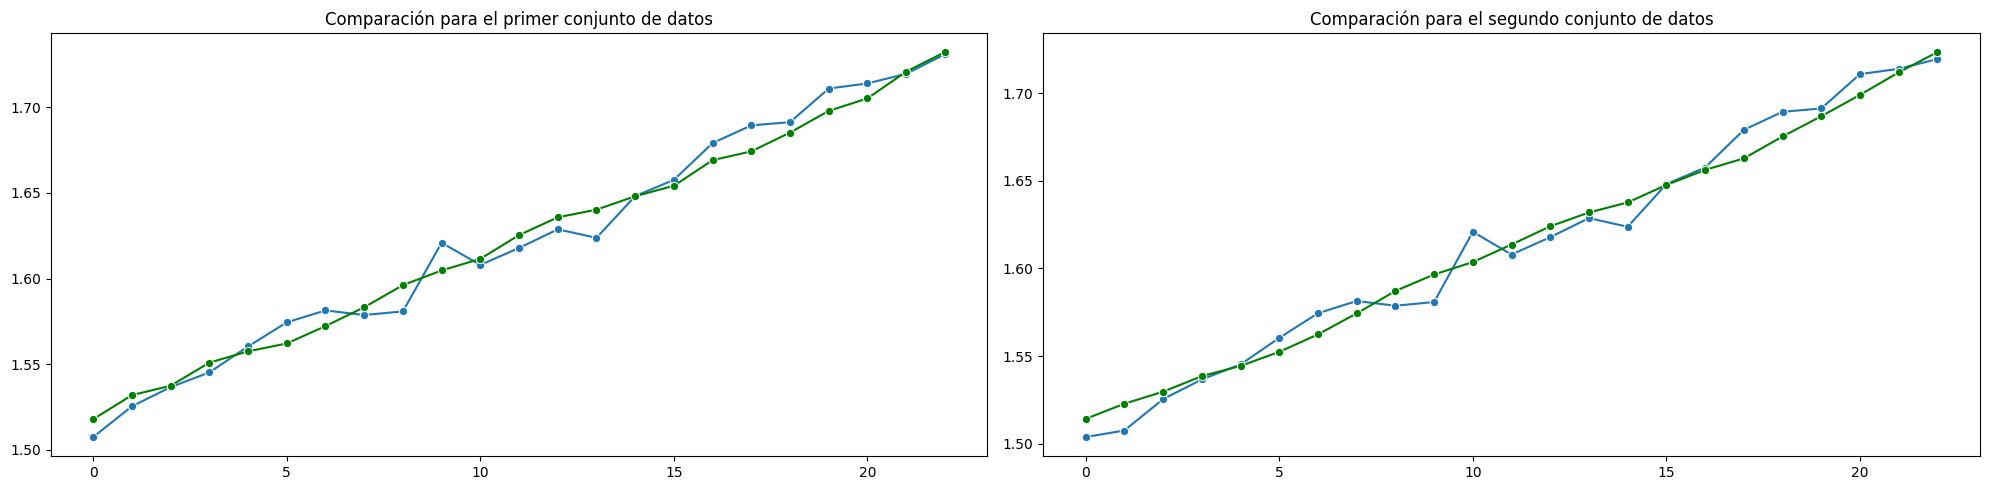

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Graficar y_test y y_pred_multi en la primera subparcela
sns.lineplot(data=y_test[:, 1], marker='o', ax=axes[0])
sns.lineplot(data=y_pred_multi[:, 1], color="green", marker='o', ax=axes[0])
axes[0].set_title('Comparación para el primer conjunto de datos')

# Graficar y_test y y_pred_multi en la segunda subparcela
sns.lineplot(data=y_test[:, 0], marker='o', ax=axes[1])
sns.lineplot(data=y_pred_multi[:, 0], color="green", marker='o', ax=axes[1])
axes[1].set_title('Comparación para el segundo conjunto de datos')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()